## Transfer learning CIFAR-10 using ViT, AlexNet and ResNet34
Authors: Rohan Subramanian, Sahil Rane and Forrest Bicker

In this notebook, we demonstrate how to fine-tune three different models on the CIFAR-10 dataset.

We would like to credit the following open source code which was used as reference:
<ul>
    <li> <a href='https://github.com/rasbt/deeplearning-models/tree/master'>Deep Learning Models</a> by Sebastian Raschka: A collection of various deep learning architectures, models, and tips for PyTorch in Jupyter Notebooks. The <a href='https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-alexnet-cifar10.ipynb'>specific tutorial</a> was for AlexNet training. </li>
    <li><a href="https://github.com/NielsRogge/Transformers-Tutorials/tree/master">Transformers Tutorials</a> by Niels Rogge: demos made with the Transformers library by HuggingFace. The <a href='https://github.com/NielsRogge/Transformers-Tutorials/blob/master/VisionTransformer/Fine_tuning_the_Vision_Transformer_on_CIFAR_10_with_the_%F0%9F%A4%97_Trainer.ipynb'>specific tutorial</a> was for fine-tuning the vision transformer.</li>
    <li>For specific information on hyperparameters that worked best with ResNet34, we took inspiration from Kaggle users, such as <a href='https://www.kaggle.com/code/francescolorenzo/96-fine-tuning-resnet34-with-pytorch'>this notebook</a>.</li>
</ul>

The fine-tuned models are saved to the models directory, but only the fine-tuned Resnet34 model is used for further explainablity analysis in other notebooks. 

### Load packages

In [1]:
import sys
print(sys.executable)

/mnt/cs/cs152/individual/3b1b/myenv/bin/python


In [3]:
import torch
import torchvision
from datasets import load_dataset
from transformers import ViTImageProcessor
from transformers import ViTForImageClassification
from torch.utils.data import DataLoader
import torch
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

In [36]:
from traincnn import *

In [35]:
# To clear GPU memory
import gc
torch.cuda.empty_cache()
gc.collect()

23781

## Preprocess CIFAR-10 

### Loading data

In [4]:
# load cifar10 (only small portion for demonstration purposes)
train_ds, test_ds = load_dataset('cifar10', split=['train[:5000]', 'test[:2000]'])
# split up training into training + validation
splits = train_ds.train_test_split(test_size=0.1, seed=42)
train_ds = splits['train']
val_ds = splits['test']

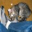

In [5]:
test_ds[0]['img']

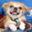

In [6]:
train_ds[0]['img']

In [7]:
train_ds[0]['label']

5

In [8]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

### Preprocessing data

In [9]:
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

In [10]:
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomResizedCrop,
                                    Resize,
                                    ToTensor)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            Resize(size),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

In [11]:
# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)


In [12]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [13]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)


pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


## Training ViT on CIFAR-10 using Hugging Face

### Define the ViT model

In [13]:
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  id2label=id2label,
                                                  label2id=label2id)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"test-cifar-10",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)


In [15]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [16]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

### Train the model

In [17]:
trainer.train()

/cs/cs152/individual/3b1b/myenv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.127033,0.948000
2,No log,0.730099,0.958000
3,1.329300,0.641265,0.970000


/cs/cs152/individual/3b1b/myenv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/cs/cs152/individual/3b1b/myenv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=675, training_loss=1.1912412064163773, metrics={'train_runtime': 168.8627, 'train_samples_per_second': 79.947, 'train_steps_per_second': 3.997, 'total_flos': 1.046216869705728e+18, 'train_loss': 1.1912412064163773, 'epoch': 3.0})

In [24]:
model.named_modules

<bound method Module.named_modules of ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
   

In [31]:
 trainer.save_model("./models/vit_cifar10")

### Evaluate model

In [32]:
outputs = trainer.predict(test_ds)

/mnt/cs/cs152/individual/3b1b/myenv/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [33]:
print(outputs.metrics)

{'test_loss': 0.6455102562904358, 'test_accuracy': 0.9635, 'test_runtime': 34.7917, 'test_samples_per_second': 57.485, 'test_steps_per_second': 7.186}


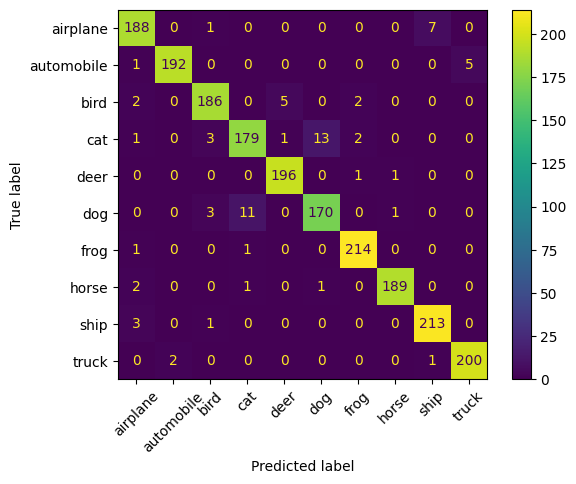

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

## Training AlexNet on CIFAR-10

In [102]:
from torchvision.models import alexnet
from torchvision.models import AlexNet_Weights
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms

In [103]:
class CIFAR10TorchvisionDataset:
  def __init__(self, transformer_dataset):
    self.transformer_dataset = transformer_dataset

  def __getitem__(self, i):
    elem = self.transformer_dataset.__getitem__(i)
    return (_train_transforms(elem['img']), elem['label'])

  def __len__(self):
    return len(self.transformer_dataset)

train_dataset = CIFAR10TorchvisionDataset(train_ds)

In [104]:
cnn = alexnet(num_classes=1000, weights=AlexNet_Weights.IMAGENET1K_V1)

In [105]:
cnn.classifier[6] = nn.Linear(4096, 10)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

for parameters in cnn.parameters():
    parameters.requires_grad = True
if torch.cuda.is_available():
    cnn = cnn.to('cuda')

In [111]:
train_dataloader = DataLoader(CIFAR10TorchvisionDataset(train_ds), batch_size=128)
val_dataloader = DataLoader(CIFAR10TorchvisionDataset(val_ds), batch_size=128)
test_dataloader = DataLoader(CIFAR10TorchvisionDataset(test_ds), batch_size=128)

In [113]:
NUM_EPOCHS = 20
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

cnn.to(DEVICE)

minibatch_loss_list, train_acc_list, valid_acc_list = train_classifier(
        model=cnn, num_epochs=NUM_EPOCHS, train_loader=train_dataloader,
        valid_loader=val_dataloader, test_loader=test_dataloader, optimizer=optimizer,
        device=DEVICE, logging_interval=50,
        best_model_save_path="./models/alexnet_cifar10")

Epoch: 001/020 | Batch 0000/0036 | Loss: 1.7951
Epoch: 001/020 | Train: 48.98% | Validation: 48.00% | Best Validation (Ep. 001): 48.00%
Time elapsed: 0.40 min
Epoch: 002/020 | Batch 0000/0036 | Loss: 1.4821
Epoch: 002/020 | Train: 56.38% | Validation: 55.40% | Best Validation (Ep. 002): 55.40%
Time elapsed: 0.81 min
Epoch: 003/020 | Batch 0000/0036 | Loss: 1.2808
Epoch: 003/020 | Train: 59.98% | Validation: 58.60% | Best Validation (Ep. 003): 58.60%
Time elapsed: 1.22 min
Epoch: 004/020 | Batch 0000/0036 | Loss: 1.2547
Epoch: 004/020 | Train: 63.93% | Validation: 62.40% | Best Validation (Ep. 004): 62.40%
Time elapsed: 1.62 min
Epoch: 005/020 | Batch 0000/0036 | Loss: 1.1712
Epoch: 005/020 | Train: 63.53% | Validation: 62.60% | Best Validation (Ep. 005): 62.60%
Time elapsed: 2.05 min
Epoch: 006/020 | Batch 0000/0036 | Loss: 1.1488
Epoch: 006/020 | Train: 64.91% | Validation: 64.80% | Best Validation (Ep. 006): 64.80%
Time elapsed: 2.46 min
Epoch: 007/020 | Batch 0000/0036 | Loss: 1.132

In [118]:
test_acc = compute_accuracy(cnn, test_dataloader, DEVICE)
float(test_acc)

66.70000457763672

In [141]:
compute_roc_auc(cnn, test_dataloader, DEVICE, num_classes=10)

0.9528433790726096

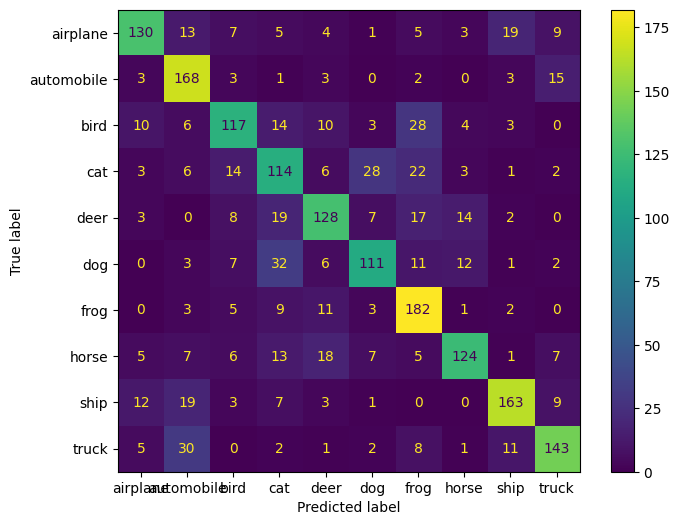

In [133]:
cf_matrix = compute_confusion_matrix(cnn, test_dataloader, DEVICE)
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
display = ConfusionMatrixDisplay(cf_matrix, display_labels=train_ds.features['label'].names)
display.plot(ax=ax);

## Training ResNet34 on CIFAR-10

In [15]:
class CIFAR10TorchvisionDataset:
  def __init__(self, transformer_dataset):
    self.transformer_dataset = transformer_dataset

  def __getitem__(self, i):
    elem = self.transformer_dataset.__getitem__(i)
    return (_train_transforms(elem['img']), elem['label'])

  def __len__(self):
    return len(self.transformer_dataset)

train_dataset = CIFAR10TorchvisionDataset(train_ds)

In [37]:
from torchvision.models import ResNet34_Weights

def get_net():
    resnet = torchvision.models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
    
    # Substitute the FC output layer
    resnet.fc = torch.nn.Linear(resnet.fc.in_features, 10)
    torch.nn.init.xavier_uniform_(resnet.fc.weight)
    return resnet

In [22]:
train_dataloader = DataLoader(CIFAR10TorchvisionDataset(train_ds), batch_size=32)
valid_dataloader = DataLoader(CIFAR10TorchvisionDataset(val_ds), batch_size=32)
test_dataloader = DataLoader(CIFAR10TorchvisionDataset(test_ds), batch_size=32)

In [23]:
import time

def train(net, train_dataloader, valid_dataloader, criterion, optimizer, epochs=10, device='cpu'):
    start = time.time()
    print(f'Training for {epochs} epochs on {device}')

    # Initialize lists to store metrics for each epoch
    epoch_train_losses = []
    epoch_train_accuracies = []
    epoch_valid_losses = []
    epoch_valid_accuracies = []
    
    for epoch in range(1, epochs + 1):
        print(f"Epoch {epoch}/{epochs}")

        net.train()  # put network in train mode
        batch_train_losses = []
        batch_train_accuracies = []
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)
            preds = net(X)
            loss = criterion(preds, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                batch_train_losses.append(loss.item())
                correct = (torch.argmax(preds, dim=1) == y).sum().item()
                batch_train_accuracies.append(correct / X.shape[0])

        # Store the batch metrics for the current epoch
        epoch_train_losses.append(batch_train_losses)
        epoch_train_accuracies.append(batch_train_accuracies)
        
        if valid_dataloader is not None:
            net.eval()  # put network in eval mode
            batch_valid_losses = []
            batch_valid_accuracies = []
            with torch.no_grad():
                for X, y in valid_dataloader:
                    X, y = X.to(device), y.to(device)
                    preds = net(X)
                    loss = criterion(preds, y)
                    
                    batch_valid_losses.append(loss.item())
                    correct = (torch.argmax(preds, dim=1) == y).sum().item()
                    batch_valid_accuracies.append(correct / X.shape[0])

            # Store the batch metrics for the current epoch
            epoch_valid_losses.append(batch_valid_losses)
            epoch_valid_accuracies.append(batch_valid_accuracies)

        # Print epoch summary
        print(f'Epoch {epoch} - Training loss: {sum(batch_train_losses)/len(batch_train_losses):.2f}, Training accuracy: {100*sum(batch_train_accuracies)/len(batch_train_accuracies):.2f}%')
        if valid_dataloader is not None:
            print(f'Epoch {epoch} - Validation loss: {sum(batch_valid_losses)/len(batch_valid_losses):.2f}, Validation accuracy: {100*sum(batch_valid_accuracies)/len(batch_valid_accuracies):.2f}%')
        print()
    
    end = time.time()
    print(f'Total training time: {end-start:.1f} seconds')

    # Return the collected metrics
    return net, (epoch_train_losses, epoch_train_accuracies, epoch_valid_losses, epoch_valid_accuracies)

# Usage:
# trained_net, metrics = train(net, train_dataloader, valid_dataloader, criterion, optimizer, epochs=10, device='cuda')
# train_losses, train_accuracies, valid_losses, valid_accuracies = metrics

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr, weight_decay, epochs = 1e-5, 5e-4, 5

net = get_net().to(device)

# Standard CrossEntropy Loss for multi-class classification problems
criterion = torch.nn.CrossEntropyLoss()

# params_1x are the parameters of the network body, i.e., of all layers except the FC layers
params_1x = [param for name, param in net.named_parameters() if 'fc' not in str(name)]
optimizer = torch.optim.Adam([{'params':params_1x}, {'params': net.fc.parameters(), 'lr': lr*10}], lr=lr, weight_decay=weight_decay)

net, (batch_train_losses, batch_train_accuracies, batch_valid_losses, batch_valid_accuracies) = train(net, train_dataloader, valid_dataloader, criterion, optimizer, epochs=5, device=device)

/mnt/cs/cs152/individual/3b1b/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/cs/cs152/individual/3b1b/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training for 5 epochs on cuda
Epoch 1/5
Epoch 1 - Training loss: 1.42, Training accuracy: 52.44%
Epoch 1 - Validation loss: 0.82, Validation accuracy: 72.34%

Epoch 2/5
Epoch 2 - Training loss: 0.44, Training accuracy: 87.55%
Epoch 2 - Validation loss: 0.61, Validation accuracy: 80.59%

Epoch 3/5
Epoch 3 - Training loss: 0.19, Training accuracy: 97.32%
Epoch 3 - Validation loss: 0.54, Validation accuracy: 82.15%

Epoch 4/5
Epoch 4 - Training loss: 0.08, Training accuracy: 99.71%
Epoch 4 - Validation loss: 0.52, Validation accuracy: 82.34%

Epoch 5/5
Epoch 5 - Training loss: 0.04, Training accuracy: 99.96%
Epoch 5 - Validation loss: 0.51, Validation accuracy: 83.32%

Total training time: 60.6 seconds


In [34]:
torch.save(net, "./models/resnet_cifar10")

### ResNet evaluation

In [26]:
test_acc = compute_accuracy(net, test_dataloader, device)
float(test_acc)

84.3499984741211

In [27]:
compute_roc_auc(net, test_dataloader, device, num_classes=10)

0.9861873631845866

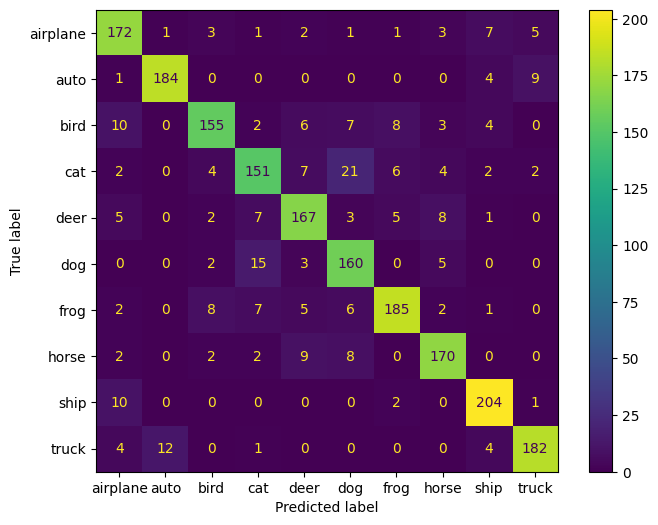

In [57]:
cf_matrix = compute_confusion_matrix(net, test_dataloader, device)
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
labels = ['airplane', 'auto', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
display = ConfusionMatrixDisplay(cf_matrix, display_labels=labels)
display.plot(ax=ax);
plt.savefig("./figures/resnet-cfmat.pdf", format="pdf", bbox_inches="tight")

In [28]:
class_accuracies = compute_class_accuracy(net, test_dataloader, device)
for class_id, acc in class_accuracies.items():
    print(f"Accuracy for class {id2label[class_id]}: {acc:.2f}%")

Accuracy for class cat: 75.88%
Accuracy for class ship: 94.01%
Accuracy for class airplane: 80.61%
Accuracy for class frog: 91.67%
Accuracy for class automobile: 92.42%
Accuracy for class truck: 86.21%
Accuracy for class dog: 81.08%
Accuracy for class horse: 81.35%
Accuracy for class deer: 77.78%
Accuracy for class bird: 80.51%


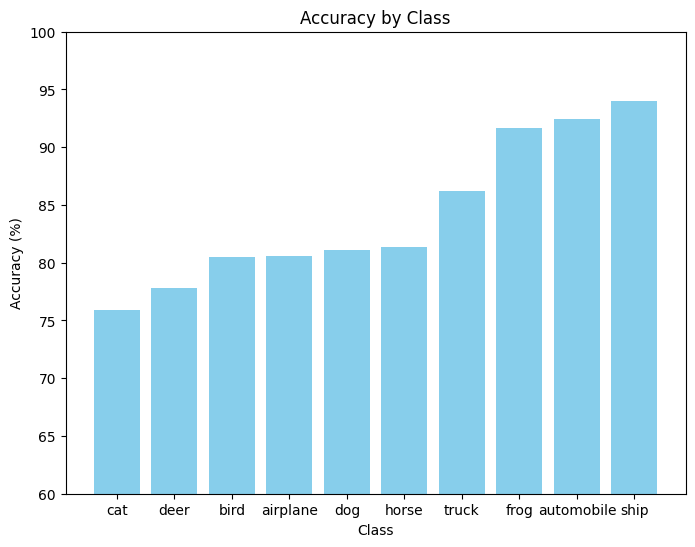

In [29]:
# Sorting the dictionary by its values and then unpacking into separate lists
sorted_classes, sorted_accuracies = zip(*sorted(class_accuracies.items(), key=lambda x: x[1]))
sorted_classes = [id2label[i] for i in sorted_classes]

# Creating the bar chart with sorted data
plt.figure(figsize=(8, 6))

plt.bar(sorted_classes, sorted_accuracies, color='skyblue')

# Adding labels and title
plt.ylim(60,100)
plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy by Class')
plt.xticks(sorted_classes)  # Set x-ticks to sorted class labels
plt.savefig("./figures/resnet-classacc.pdf")
plt.show()

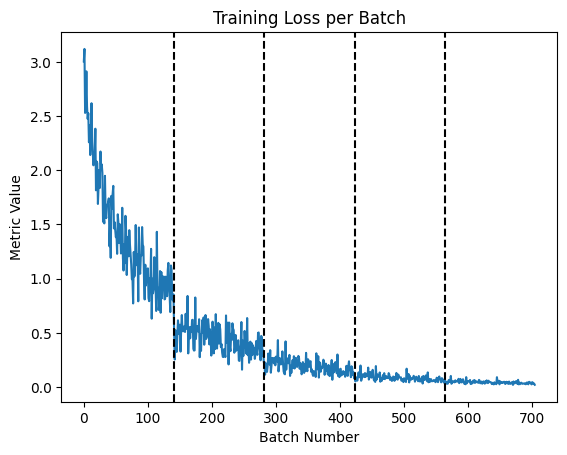

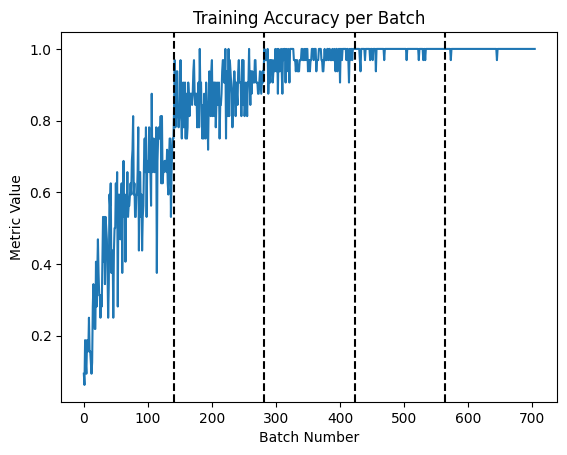

In [33]:
# Flattening function and epoch end position calculation function remain the same
def flatten_metrics(metrics):
    # Flatten the list of lists
    flattened = [item for sublist in metrics for item in sublist]
    return flattened

def calculate_epoch_end_positions(metrics):
    positions = []
    counter = 0
    for epoch_metrics in metrics:
        counter += len(epoch_metrics)
        positions.append(counter)
    return positions[:-1]  # Exclude the last position

# Flatten the metrics
flat_train_losses = flatten_metrics(batch_train_losses)
flat_train_accuracies = flatten_metrics(batch_train_accuracies)

# Calculate epoch end positions
epoch_end_positions = calculate_epoch_end_positions(batch_train_losses)

# Plotting function
def plot_metrics_with_epochs(metrics, epoch_positions, title, filename):
    plt.figure()
    plt.plot(metrics)

    # Add vertical lines for epoch demarcation
    for pos in epoch_positions:
        plt.axvline(x=pos, color='black', linestyle='--')

    plt.title(title)
    plt.xlabel('Batch Number')
    plt.ylabel('Metric Value')
    plt.savefig(f"./figures/{filename}.pdf", format='pdf')
    plt.show()

# Plotting
plot_metrics_with_epochs(flat_train_losses, epoch_end_positions, 'Training Loss per Batch', "resnet-batchloss")
plot_metrics_with_epochs(flat_train_accuracies, epoch_end_positions, 'Training Accuracy per Batch', "resnet-batchacc")